# Categorizing retinal ganglion celltypes with density-based clustering
Here, we examine the response of RGCs to a protocol inspired by Baden 2016.
The recording uses a 3Brain CMOS MEA with 4096 channels

author: Tyler Benster

date: 2020-07-03

## imports

will need to install all dependencies, including glia: https://github.com/tbenst/glia

In [1]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import glia
from glia.config import channel_map
import pandas as pd
from importlib import reload
import csv
import seaborn as sns
from scipy import signal
import numpy as np
import scipy
import os
import sys
import traceback
import glia
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import datasets, svm, metrics, neighbors
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import os
from functools import reduce, partial
from scipy import stats
from pathlib import Path
from tqdm import tqdm

reload(glia)
from sklearn.decomposition import PCA
from scipy.stats import vonmises
from scipy.signal import chirp

## Drivers (key parameters)

In [2]:
plt.rcParams["font.size"] = 18
data_dir = "/storage/uw/3brain/200623_faces/"

fig_dict = {}
fig_dict["plot_name"] = "R1_E2_AMES_120min_celltyping"
fig_dict["filename"] = data_dir + "R1_E2_AMES_120min_celltyping"
fig_dict["notebook"] = data_dir + "lab notebook.yaml"

## Data loading

In [3]:
name = fig_dict["plot_name"]
filename = fig_dict["filename"]
notebook = fig_dict["notebook"]

data_directory, data_name = os.path.split(filename)
lab_notebook = glia.open_lab_notebook(fig_dict["notebook"])

name, extension = os.path.splitext(data_name)
stimulus_file = os.path.join(data_directory, name + ".stim")
metadata, stimulus_list, method = glia.read_stimulus(stimulus_file)

In [4]:
channel_map = glia.config.channel_map_3brain
spikes = glia.read_3brain_spikes(Path(data_directory) / (name +".bxr"), name, channel_map)

In [5]:
def filter_celltyping(l):
    return list(filter(lambda x: "label" in x["stimulus"]["metadata"] and \
        x["stimulus"]["metadata"]["label"]=="celltype", l))

def remove_stimulus(l, stimulusTypes):
    return list(filter(lambda x: not x["stimulus"]["stimulusType"] in stimulusTypes, l))

def remove_stimulusIndex_range(l, startIdx, stopIdx):
    return list(filter(lambda x: x["stimulus"]["stimulusIndex"] < startIdx or x["stimulus"]["stimulusIndex"] > stopIdx, l))

# select cell
get_celltyping = glia.compose(
    glia.f_create_experiments(stimulus_list),
    filter_celltyping,
    )

get_fullfield = glia.compose(
    partial(remove_stimulus, stimulusTypes=["IMAGE", "BAR"]),
    # remove WAITs in between BAR (stimulusIndex 9-54)
    # WARNING: if celltyping is updated, these hardcoded numbers may need to change
    partial(remove_stimulusIndex_range, startIdx=9, stopIdx=54)
)
celltyping_responses = glia.apply_pipeline(get_celltyping,spikes, progress=True)
celltyping_responses_fullfield = glia.apply_pipeline(get_fullfield, celltyping_responses)
celltyping_responses_noise = glia.apply_pipeline(glia.f_has_stimulus_type("IMAGE"), celltyping_responses)

  0%|          | 10/4009 [00:00<00:40, 98.46it/s]

Applying pipeline


100%|██████████| 4009/4009 [00:40<00:00, 99.60it/s] 


Applying pipeline
Applying pipeline


In [6]:
celltyping_responses_fullfield = glia.apply_pipeline(partial(remove_stimulus, stimulusTypes=["IMAGE", "BAR"]), celltyping_responses)

Applying pipeline


In [7]:
celltyping_responses_bar = glia.apply_pipeline(
    glia.compose(glia.f_has_stimulus_type("BAR"),
                 glia.f_group_by("angle"),
                 glia.f_map(lambda x: x[0]), # only 1 stimuli in group, no reps
                 glia.count_spikes),
    celltyping_responses)

Applying pipeline


In [8]:
bar_spike_count = {k: sum(v.values()) for k,v in celltyping_responses_bar.items()}

In [9]:
def fit_von_mises_from_angle_dict(angle_dict, stabilize=True, fscale=1):
    """Take a dict with angle (0 to 2pi) as key and spike count as value. Return Von Mises Kappa.
    
    If stabilize=True, we add 1 spike for each angle for numerical stability
    (else a single spike to one direction will have a high kappa)
    
    TODO: test if scipy handles non-zero mean properly. May need to mean center at 0.
    Need to specify fscale=1 else get bad fits sometimes......
    https://stackoverflow.com/questions/39020222/python-scipy-how-to-fit-a-von-mises-distribution
    https://github.com/scipy/scipy/issues/8878"""
    samples = []
    for angle, count in angle_dict.items():
        samples += [angle - np.pi] * count
    if stabilize:
        samples += list(angle_dict.keys())
    if len(samples)==0:
        # no response to any moving bar is a uniform response
        # thus, kappa is 0
        return 0
    if not fscale is None:
        kappa, loc, scale = vonmises.fit(samples, fscale=fscale)
    else:
        kappa, loc, scale = vonmises.fit(samples)
    return kappa, loc, scale

In [10]:
kappas = glia.pmap(fit_von_mises_from_angle_dict, celltyping_responses_bar, progress=True)

100%|██████████| 4009/4009 [06:53<00:00,  9.23it/s]


In [11]:
most_selective_units = sorted([(k,sc,kappa[0]) for k, (sc,kappa) in glia.zip_dictionaries(bar_spike_count, kappas)], key=lambda x: x[2])

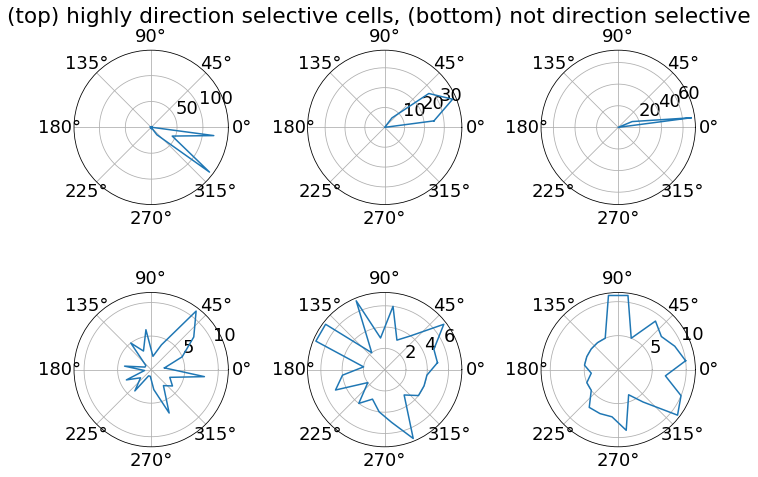

In [12]:
def plot_angle_dict(ax, angle_dict):
    angles = list(angle_dict.keys())
    values = list(angle_dict.values())
    # connect line
    angles += [angles[0]]
    values += [values[0]]
    ax.plot(angles, values)
    
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(231, projection='polar')
ax2 = fig.add_subplot(232, projection='polar')
ax3 = fig.add_subplot(233, projection='polar')
ax4 = fig.add_subplot(234, projection='polar')
ax5 = fig.add_subplot(235, projection='polar')
ax6 = fig.add_subplot(236, projection='polar')
plot_angle_dict(ax1, celltyping_responses_bar[most_selective_units[-1][0]])
plot_angle_dict(ax2, celltyping_responses_bar[most_selective_units[-2][0]])
plot_angle_dict(ax3, celltyping_responses_bar[most_selective_units[-3][0]])
plot_angle_dict(ax4, celltyping_responses_bar[most_selective_units[200][0]])
plot_angle_dict(ax5, celltyping_responses_bar[most_selective_units[201][0]])
plot_angle_dict(ax6, celltyping_responses_bar[most_selective_units[202][0]])
plt.suptitle("(top) highly direction selective cells, (bottom) not direction selective")
plt.tight_layout()
# note how bottom left corner is actually orientation selective...
# Von Mises is great for characterizing DS but not so great for OS

In [13]:
# 0 WAIT
# 3 SOLID (white)
# 6 wait
# 9 SOLID (gray)
# 12 Chirp
# 20 wait
# 23 chirp
# 31 wait
# 33 wait
# 35 green
# 38 wait
# 41 blue
# 44 wait

#un

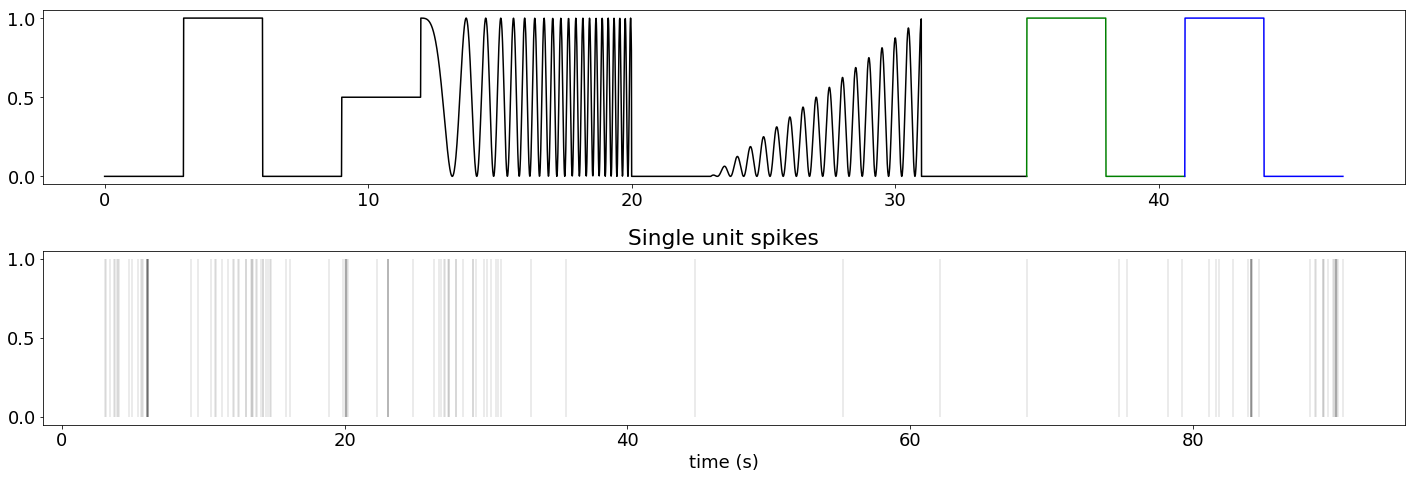

In [14]:
# good units:
# 221, 190
un = celltyping_responses_fullfield[most_selective_units[190][0]]
spike_train = np.array([])
start_time = 0
for stim in un:
    spikes = stim["spikes"] + start_time
    spike_train = np.concatenate([spike_train, spikes])
    start_time += stim["stimulus"]["lifespan"]

fullfield_stim_duration = start_time

t = np.arange(0, 8, 0.01)
w = chirp(t, f0=0.05, f1=5, t1=8, method='linear')
w2 = chirp(t, f0=2, f1=2, t1=8, method='linear')

# TODO: this should not be hardcoded--add up from stimulus_list!!
# also, it's actually 93 second...? Not 47...?
plt.figure(figsize=(20,7))
plt.subplot(211)
fullfield_time = np.arange(0,35,0.01)
green_time = np.arange(35-0.01,41-0.01,0.01)
blue_time = np.arange(41-0.01,47,0.01)
fullfield_stim = np.zeros(3500)
green_stim = np.zeros(600)
blue_stim = np.zeros(601)
fullfield_stim[300:600] = 1
fullfield_stim[900:1200] = 0.5
fullfield_stim[1200:2000] = (w+1)/2
fullfield_stim[2300:3100] = (w2+1)/2*np.arange(0,8,0.01)/8
green_stim[1:301] = 1
blue_stim[1:301] = 1
# TODO chirp plot should start at 0.5 and rise
plt.plot(fullfield_time, fullfield_stim, color='k')
plt.plot(green_time, green_stim, color='g')
plt.plot(blue_time, blue_stim, color='b')
# plt.xlim(0,46)

plt.subplot(212)
plt.vlines(spike_train, 0, 1,colors='k',alpha=0.1)
# plt.fill([1,1.5,1.5,1], [-0.1,-0.1,1.1,1.1], alpha=0.2)
# plt.xlim(0,3.5)
plt.title("Single unit spikes")
plt.xlabel("time (s)")
# plt.xlim(0,46)
plt.tight_layout()

### normalization & firing rate calculation

In [15]:
nCells = len(celltyping_responses_fullfield)

In [17]:
for i, un in enumerate(celltyping_responses_fullfield.keys()):
    if un==most_selective_units[190][0]:
        print(i)

2806


In [18]:
# bin spikes each 1ms for signal processing
rgcs = np.zeros((nCells, fullfield_stim_duration * 1000), dtype=np.uint8) # 1 ms bins
bins = np.arange(0, fullfield_stim_duration+0.001, 0.001)
for i, un in enumerate(celltyping_responses_fullfield.values()):
    spike_train = np.array([])
    start_time = 0
    for stim in un:
        un_spikes = stim["spikes"] + start_time
        spike_train = np.concatenate([spike_train, un_spikes])
        start_time += stim["stimulus"]["lifespan"]
    un_spike_train = np.histogram(spike_train, bins)[0]
    rgcs[i] = un_spike_train

In [19]:
spike_counts = np.sum(rgcs,1)


# estimate firing rate using gaussian smoothing
sigma = 6
bandwidth = 0.05 # sec
bin_width = 0.001
transformed_sigma = bandwidth/bin_width
window = signal.gaussian(2*sigma*transformed_sigma, std=transformed_sigma)

# instantaneous firing rate (acausal)
ifr = np.array([signal.convolve(unit, window,mode="same")*1/bandwidth for unit in rgcs])

### select rgcs to analyze

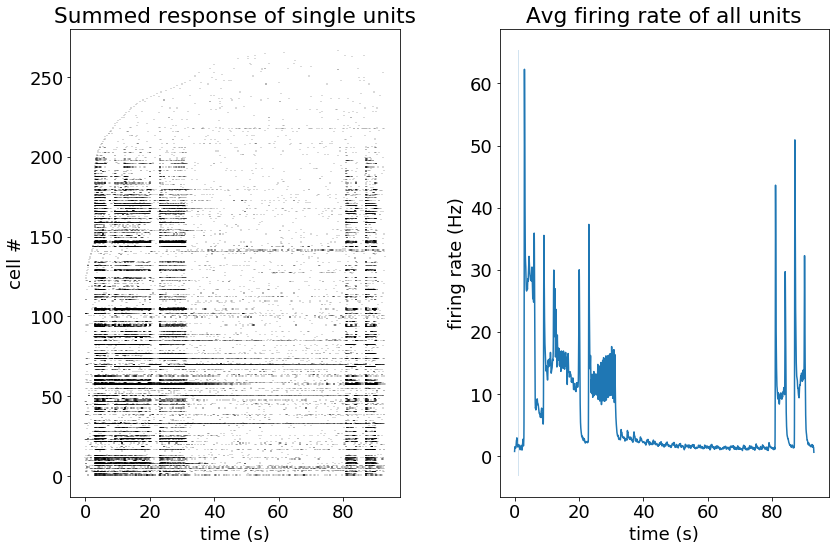

In [20]:
# each trial has three stimuli: 1s dark, 0.5s light, 2s dark
# Note: right now the firing rate kernel is acausal,
# hence response "starting" 0.05 seconds before onset of light

plt.figure(figsize=(12,8))
plt.subplot(121)

if nCells > 400:
    # visualize every 15th cell
    # matplotlib starts dropping lines if plotting too many without sufficient height
    every_k = 15
else:
    every_k = 1
for i,r in enumerate(range(0,nCells, every_k)):
    plt.vlines(np.where(rgcs[r])[0]/1000, i+0.3, i+1,colors='k',alpha=0.2)
plt.xlabel("time (s)")
plt.ylabel("cell #")
plt.title(f"Summed response of single units")

plt.subplot(122)
summed_response = np.array(ifr.sum(axis=0)) / nCells
plt.plot(np.arange(ifr.shape[1])/1000, summed_response)
shade_max = summed_response.max()
shade_min = 0 - 0.05 * shade_max
shade_max += 0.05 * shade_max
plt.fill([1,1.5,1.5,1], [shade_min,shade_min,shade_max,shade_max], alpha=0.2)
plt.xlabel("time (s)")
plt.ylabel("firing rate (Hz)")
plt.title("Avg firing rate of all units")

plt.tight_layout()

### cluster

In [44]:
# include kappa & location
kappas_mat = np.array(list(kappas.values()))[:,:1]

In [37]:
pca = sklearn.decomposition.PCA(n_components=5)
lowdim_data = pca.fit_transform(ifr)

array([[ 1418.02561397,  -492.37143359,  1264.37703817,  -458.64608348,
          -93.51602939],
       [ 3748.47082039,   -45.08628924,   152.86751374,  -184.68684605,
          456.75033852],
       [ 4731.96139119,   350.12972831,  -133.27990728,  -715.11082732,
         1099.20777747],
       ...,
       [-3144.05027465,  -207.8718636 ,  -144.57767422,   160.20605606,
          183.67598558],
       [-3144.05027465,  -207.8718636 ,  -144.57767422,   160.20605606,
          183.67598558],
       [-3144.05027465,  -207.8718636 ,  -144.57767422,   160.20605606,
          183.67598558]])

In [47]:
data = np.concatenate([lowdim_data, kappas_mat],axis=1)

In [71]:
# plt.scatter(lowdim_data[:,0],lowdim_data[:,1],c=cells.cluster)

# handcrafted bins
# lowdim_data = np.concatenate([
#         np.sum(data[:,0:5],1,keepdims=True),
#         np.sum(data[:,5:7],1,keepdims=True),
#         np.sum(data[:,7:11],1,keepdims=True),
#         np.sum(data[:,11:13],1,keepdims=True),
#         np.sum(data[:,13:15],1,keepdims=True),
#     ], 1)

# rgcs.where(rgcs.apply(lambda x: bool(exp_type[x.index])))
# cluster the data

# optics = sklearn.cluster.OPTICS(min_samples=20, xi=.05, metric='cosine')
# optics = sklearn.cluster.OPTICS(min_samples=30, xi=.02,metric="cosine") # 4 clusters
# optics = sklearn.cluster.OPTICS(min_samples=50, xi=.01,metric="cosine")
# metric = "l1"
# metric = "rogerstanimoto"

#### good settings ####
## for all retinas
# metric = "cosine"
# xi = 0.05
# min_samples = 50

## for single retina
# metric = "cosine"
# xi = 0.05
# min_samples = 8
#######################

metric = "cosine"
xi = 0.01
min_samples = 20

# data_cov = np.cov(data.transpose())
# optics = sklearn.cluster.OPTICS(min_samples=min_samples, xi=xi ,metric=metric, metric_params={'V': data_cov+np.random.randn(*data_cov.shape)*1e-8})
optics = sklearn.cluster.OPTICS(min_samples=min_samples, xi=xi ,metric=metric)
# optics = sklearn.cluster.OPTICS(xi=xi ,metric=metric)
# optics = sklearn.cluster.DBSCAN(metric=metric,eps=0.01,min_samples=7)
optics.fit(data)
# optics.fit(data)

labels = optics.labels_
nclust = max(labels)+1
palette = sns.color_palette("colorblind", nclust)

print(nclust)

def plot_cluster_traces(labels, ifr, csv_name=None):
    """
        data: matrix used for clustering
        r
    """
    cells = []
    ncells = []
    nclust = max(labels)+1
    print(nclust)
    # for c in range(-1,nclust):
    # ignore unclustered
    for c in range(-1,nclust):
        ncell = np.sum(labels==c)
        ncells.append(ncell)
        # cells.append(np.concatenate([np.full([ncells,1],f"clust {c}: {ncells}"),data[labels==c]],1))
        # print(len(np.array(rgcs.iloc[rows,0][labels==c])),np.sum(labels==c))
        cells.append(np.concatenate([
            np.full([ncell,1],c), # cluster
            ifr[labels==c] # firing rate
            ],1)
            )

    cells = pd.DataFrame(data=np.concatenate(cells),columns = \
        ["cluster"]+list(np.arange(ifr.shape[1])))
    # collapse columns (time) to long format, one row per timepoint
    melt_cells = cells.melt('cluster', var_name='time',  value_name='spikes')

    # Why? pandas craziness
    melt_cells.cluster = melt_cells.cluster.astype(float)
    melt_cells.spikes = melt_cells.spikes.astype(float)
    melt_cells.time = melt_cells.time.astype(float)/1000 # convert to seconds

    if csv_name:
        cells.iloc[:,:3].to_csv(f"{csv_name}.csv")

    # %#%
    # plot firing rate
    # drop unclustered
    melt_cells = melt_cells[melt_cells.cluster!=-1]
    melt_cells.cluster.unique()
    # must be categorical for seaborn
    palette = sns.color_palette("colorblind", nclust)
    len(palette)

    # melt_cells_new = melt_cells
    ymin = 0
    # letters
    ymax = 250
    # gratings
    ymax = 120
    nrow = ((nclust-1) // 4) + 1
    g = sns.FacetGrid(melt_cells, col="cluster", hue="cluster", col_wrap=4, height=nrow, ylim=(ymin, ymax), palette=palette, size=3)
    g.map(sns.lineplot, "time", "spikes", legend=False, ci="sd");

    offset = 1
    end_time = 1.5
    # offset = 4
    # end_time = 9 + 1
    for c,ax in zip(np.arange(0,nclust),g.axes):
        ax.set_title(f"clust {c}: {np.sum(labels==c)} cells")
        ax.fill([offset,end_time,end_time,offset],
                        [ymin,ymin,ymax,ymax],
                        facecolor="gray",
                        edgecolor="none", alpha=0.1)

    [ax.set_ylabel("firing rate (Hz)") for ax in g.fig.axes]
    [ax.set_xlabel("time (s)") for ax in g.fig.axes]
    return cells, g.fig

10


10


/home/tyler/lib/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


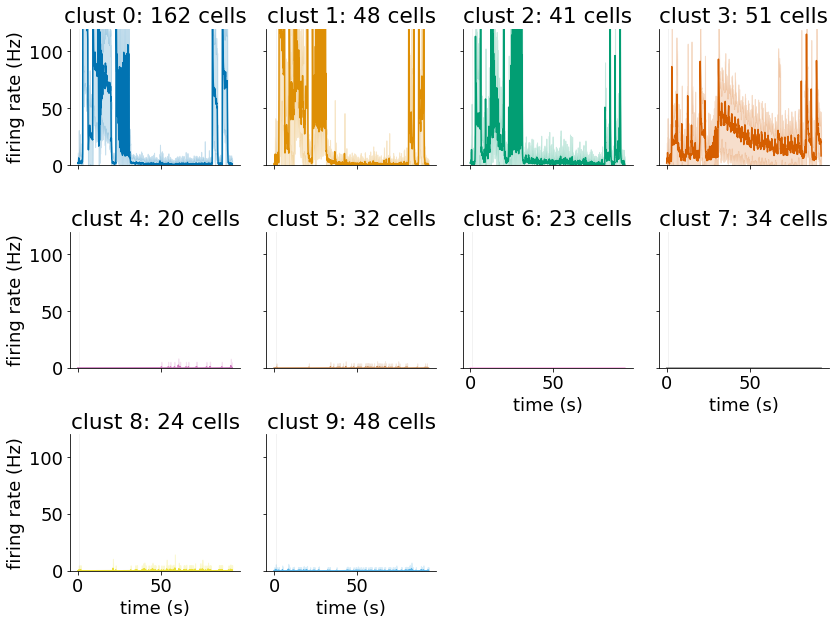

In [72]:
# WARNING: this code takes a long time to run if there 
# are a bunch of clusters. Consider interrupting if the number
# printed is above 50
# best to run on computer with lots of CPUs

# can set csv_name= to save CSV file of clustering results
# csv_name = f"{name}_cluster_optics_{cell_type_map[i]}"
csv_name = None
optics_cells, optics_cluster_traces = plot_cluster_traces(labels,ifr,csv_name)